In [1]:
import pickle
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import hdbscan
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
X = pd.read_csv('hk1_X.csv')
X.shape

(768, 43)

In [4]:
with open('hk1_uncertain_features.txt', 'rb') as fp:
    uncertain_features = pickle.load(fp)

In [5]:
X = X[uncertain_features]

In [6]:
pandas_profiling.ProfileReport(X)

Number of variables,29
Number of observations,768
Total Missing (%),0.0%
Total size in memory,174.1 KiB
Average record size in memory,232.1 B
Numeric,29
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,2


## Correlations

In [7]:
def make_correlation_graphic(df):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

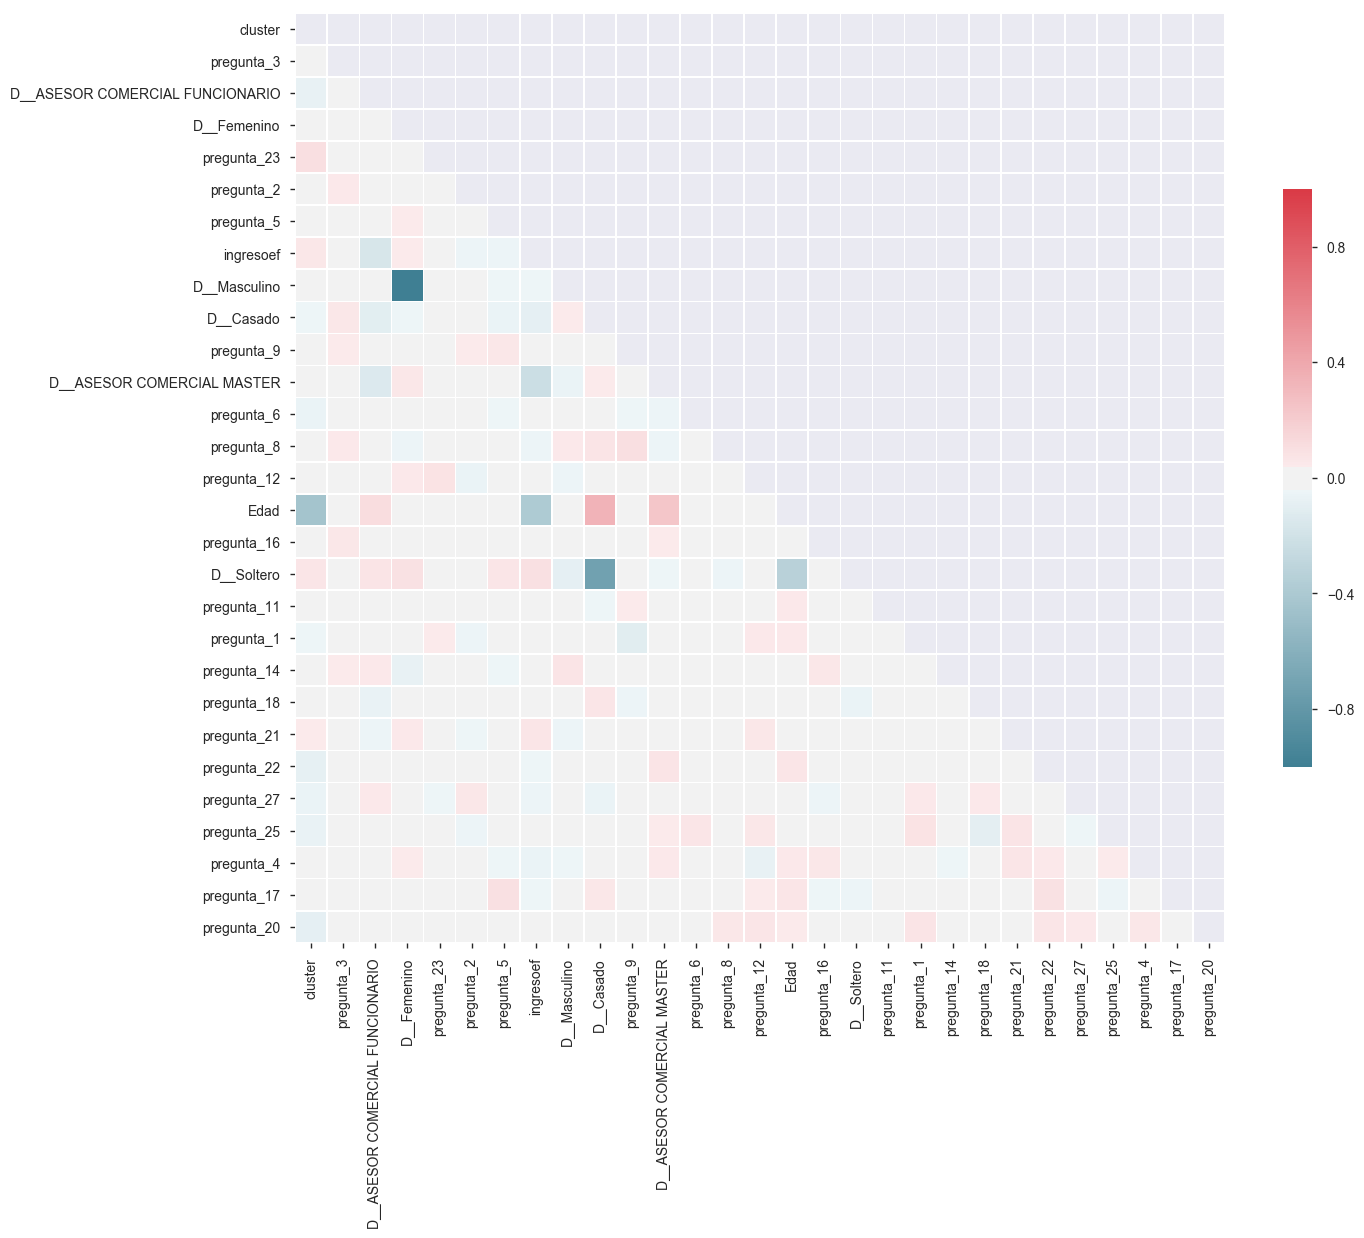

In [8]:
make_correlation_graphic(X)

# Creating target

In [9]:
y = pd.read_csv('hk1_y.csv', header=None)
y.shape

(768, 1)

In [10]:
y.columns = ['TARGET']

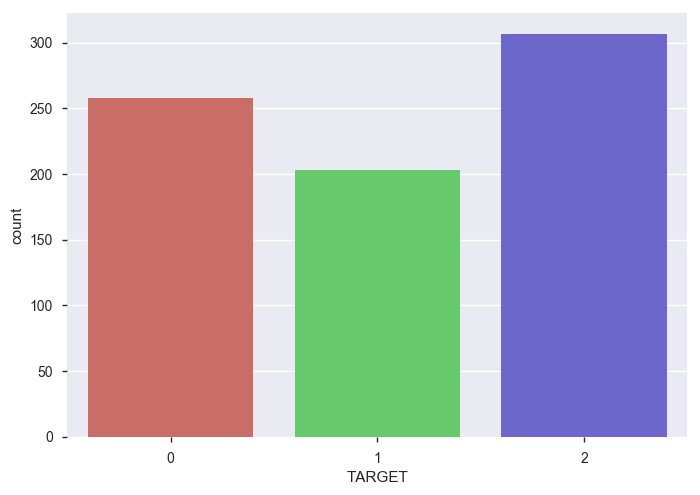

In [11]:
sns.countplot(x="TARGET", data=y, palette='hls')

# Clustering

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

,cluster,pregunta_3,D__ASESOR COMERCIAL FUNCIONARIO,D__Femenino,pregunta_23,pregunta_2,pregunta_5,ingresoef,D__Masculino,D__Casado,...,pregunta_1,pregunta_14,pregunta_18,pregunta_21,pregunta_22,pregunta_27,pregunta_25,pregunta_4,pregunta_17,pregunta_20
0,1,0.580707,1,0,0.352760,0.014503,0.191990,0,1,0,...,0.210433,0.847675,0.754865,0.155440,0.933387,0.207997,0.240581,0.475461,0.485178,0.840924
1,-1,0.058207,0,1,0.069090,0.343001,0.871500,0,0,0,...,0.789044,0.096512,0.708874,0.779381,0.929419,0.106355,0.781798,0.926026,0.911706,0.381783
2,-1,0.716495,0,1,0.102527,0.528969,0.286807,0,0,1,...,0.242838,0.591681,0.907797,0.444518,0.663385,0.272191,0.356141,0.489488,0.827381,0.869284
3,1,0.321391,1,1,0.045157,0.494812,0.645303,0,0,0,...,0.761830,0.494228,0.337379,0.929461,0.992835,0.999452,0.462822,0.524197,0.603548,0.706197
4,1,0.601921,1,1,0.905148,0.833204,0.926111,0,0,0,...,0.945418,0.519680,0.110321,0.386267,0.595219,0.459148,0.823834,0.857995,0.112340,0.839726


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

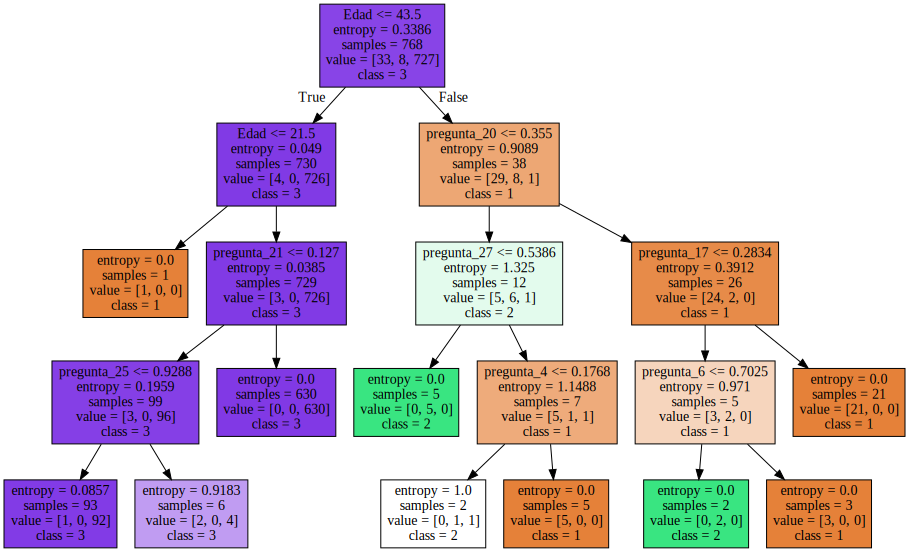

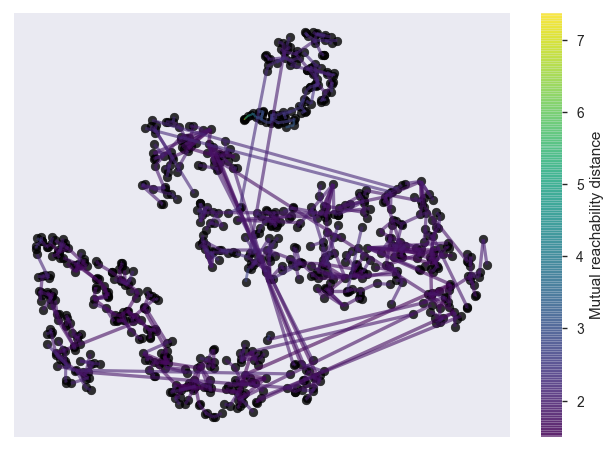

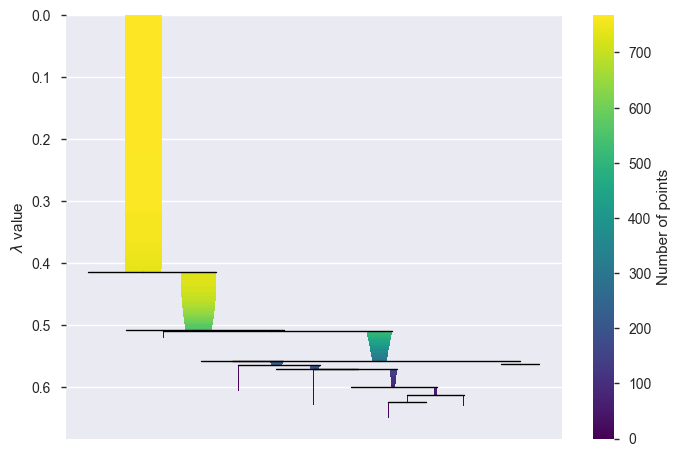

In [12]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
clusterer.fit(X)
plt.figure()
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      edge_linewidth=1)
plt.figure()
clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
X['cluster'] = pd.Series(clusterer.labels_)
X.head()
y_cluster = X['cluster']
X_cluster = X.drop('cluster', axis=1)

cluster_names = list(range(1, len(X['cluster'].value_counts()) + 1))

dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
dtc.fit(X_cluster, y_cluster)

graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

In [13]:
y = y['TARGET']

In [14]:
df = X
df['TARGET'] = y

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,pregunta_3,D__ASESOR COMERCIAL FUNCIONARIO,D__Femenino,pregunta_23,pregunta_2,pregunta_5,ingresoef,D__Masculino,D__Casado,pregunta_9,...,pregunta_14,pregunta_18,pregunta_21,pregunta_22,pregunta_27,pregunta_25,pregunta_4,pregunta_17,pregunta_20,TARGET
1,0.058207,0,1,0.069090,0.343001,0.871500,0,0,0,0.014260,...,0.096512,0.708874,0.779381,0.929419,0.106355,0.781798,0.926026,0.911706,0.381783,2
3,0.321391,1,1,0.045157,0.494812,0.645303,0,0,0,0.602978,...,0.494228,0.337379,0.929461,0.992835,0.999452,0.462822,0.524197,0.603548,0.706197,2
6,0.042709,1,1,0.434150,0.442683,0.073125,0,0,1,0.891033,...,0.541376,0.353595,0.876928,0.708068,0.373634,0.306741,0.845306,0.898584,0.210506,2
12,0.645230,0,1,0.758010,0.448876,0.501630,0,0,1,0.071521,...,0.769088,0.730291,0.154539,0.862811,0.455037,0.525541,0.514550,0.510228,0.402083,2
13,0.738945,0,1,0.035830,0.394757,0.429477,0,0,0,0.081091,...,0.142996,0.851035,0.106746,0.017470,0.165792,0.391586,0.458081,0.058614,0.328232,2


1     1.0
3     0.0
6     0.0
12    1.0
13    1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

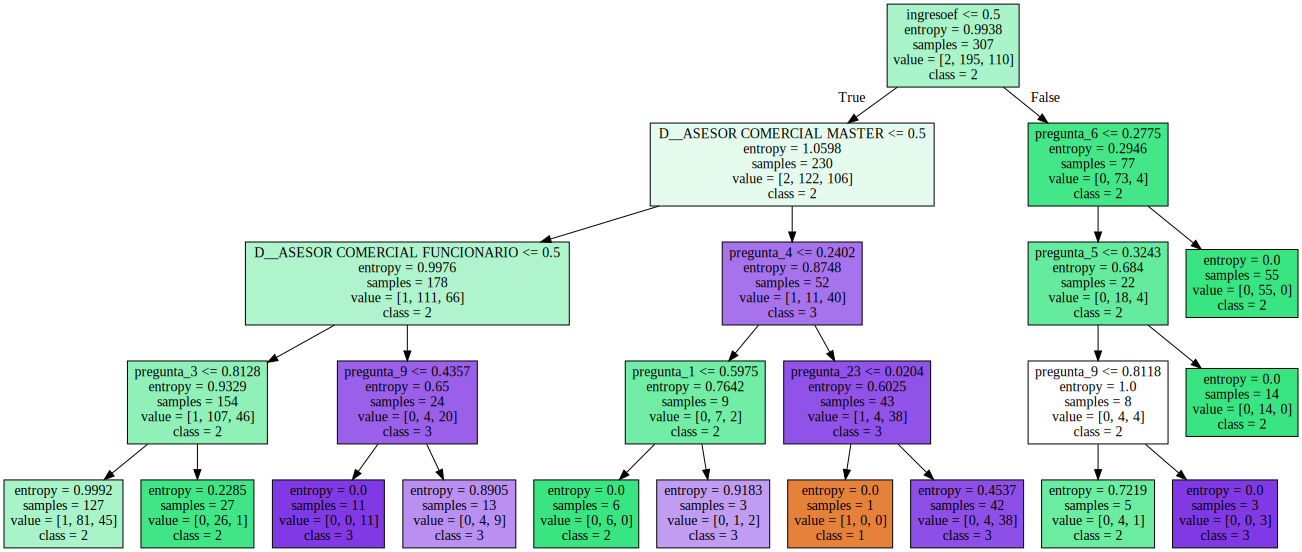

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,pregunta_3,D__ASESOR COMERCIAL FUNCIONARIO,D__Femenino,pregunta_23,pregunta_2,pregunta_5,ingresoef,D__Masculino,D__Casado,pregunta_9,...,pregunta_14,pregunta_18,pregunta_21,pregunta_22,pregunta_27,pregunta_25,pregunta_4,pregunta_17,pregunta_20,TARGET
0,0.580707,1,0,0.352760,0.014503,0.191990,0,1,0,0.767801,...,0.847675,0.754865,0.155440,0.933387,0.207997,0.240581,0.475461,0.485178,0.840924,0
2,0.716495,0,1,0.102527,0.528969,0.286807,0,0,1,0.388621,...,0.591681,0.907797,0.444518,0.663385,0.272191,0.356141,0.489488,0.827381,0.869284,0
8,0.570358,0,0,0.899919,0.217811,0.794239,0,1,0,0.635164,...,0.152424,0.984201,0.786179,0.168664,0.666562,0.140672,0.059313,0.287374,0.089392,0
9,0.718091,0,0,0.391022,0.196752,0.941359,0,1,0,0.105543,...,0.851221,0.827901,0.211351,0.906333,0.204481,0.501235,0.307564,0.948355,0.231529,0
11,0.565522,0,1,0.655400,0.730985,0.603140,0,0,1,0.092572,...,0.410692,0.995752,0.261503,0.409242,0.101436,0.967510,0.622575,0.811407,0.393594,0


0     1.0
2     1.0
8     1.0
9     1.0
11    1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

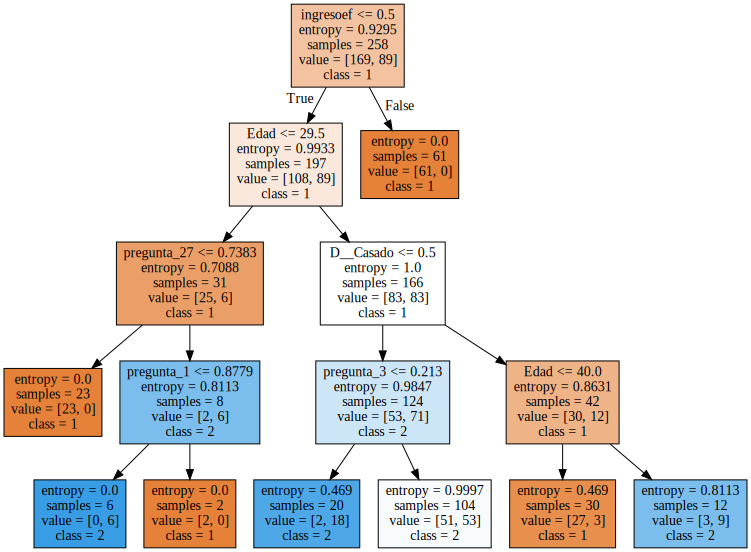

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,pregunta_3,D__ASESOR COMERCIAL FUNCIONARIO,D__Femenino,pregunta_23,pregunta_2,pregunta_5,ingresoef,D__Masculino,D__Casado,pregunta_9,...,pregunta_14,pregunta_18,pregunta_21,pregunta_22,pregunta_27,pregunta_25,pregunta_4,pregunta_17,pregunta_20,TARGET
4,0.601921,1,1,0.905148,0.833204,0.926111,0,0,0,0.383625,...,0.519680,0.110321,0.386267,0.595219,0.459148,0.823834,0.857995,0.112340,0.839726,1
5,0.613986,0,1,0.102173,0.874347,0.434296,0,0,0,0.230366,...,0.735198,0.300183,0.576545,0.479839,0.655355,0.278063,0.975214,0.472982,0.449208,1
7,0.155432,1,0,0.841421,0.787741,0.120059,0,1,0,0.352382,...,0.349763,0.424661,0.172716,0.465298,0.312323,0.310826,0.278163,0.485156,0.537438,1
10,0.386503,0,1,0.154315,0.064413,0.585383,0,0,0,0.813500,...,0.735671,0.782912,0.431442,0.068633,0.612553,0.758072,0.915506,0.127562,0.699925,1
15,0.155241,0,0,0.895153,0.129518,0.391220,0,1,0,0.979019,...,0.800481,0.083542,0.076707,0.873054,0.809196,0.549191,0.203387,0.256763,0.494980,1


4     1.0
5     1.0
7     1.0
10    1.0
15   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

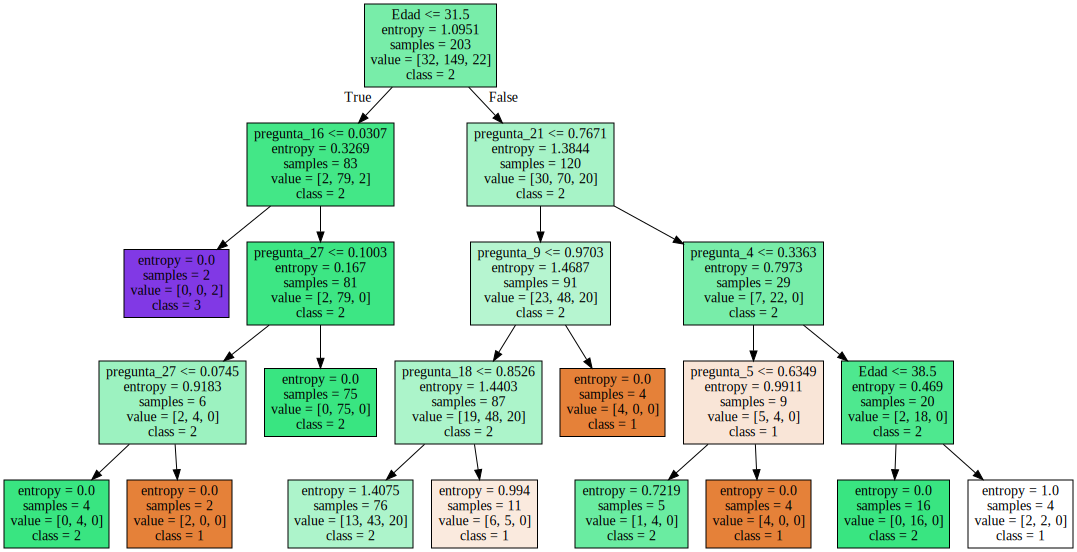

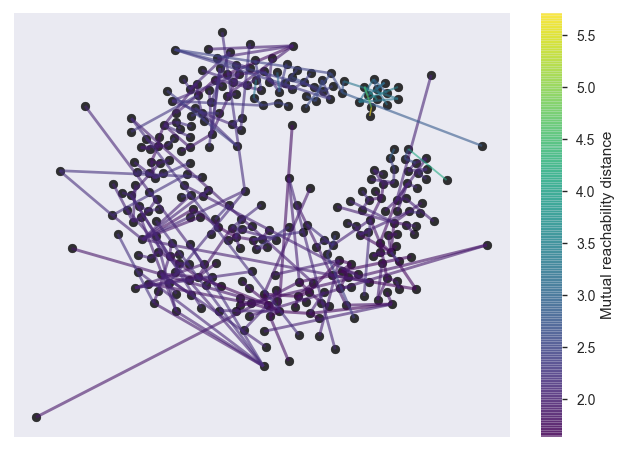

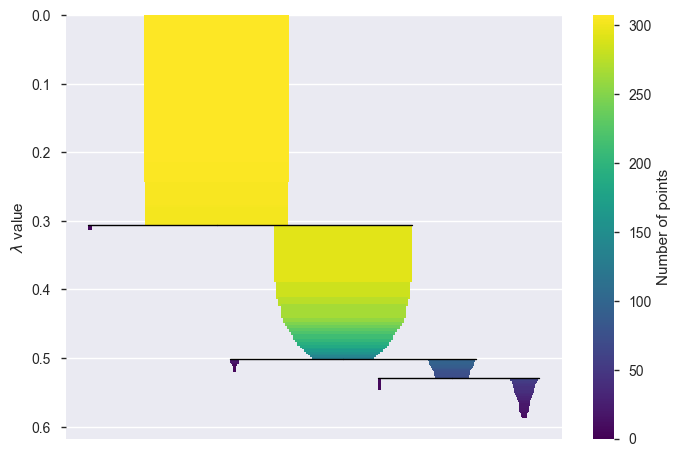

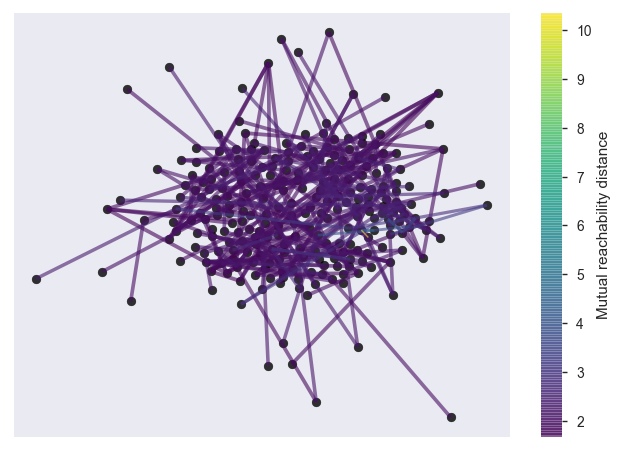

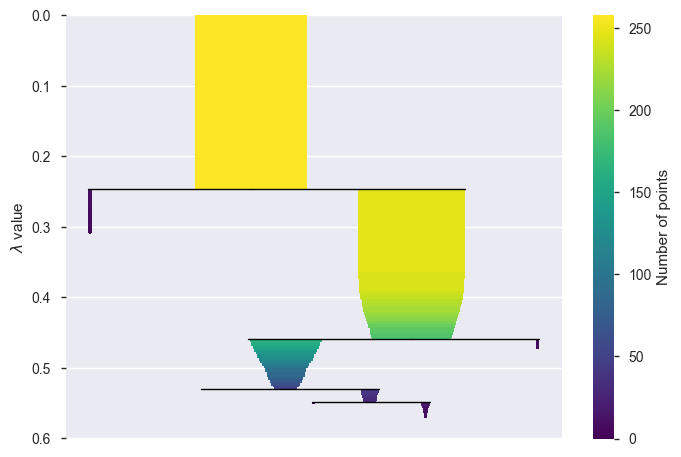

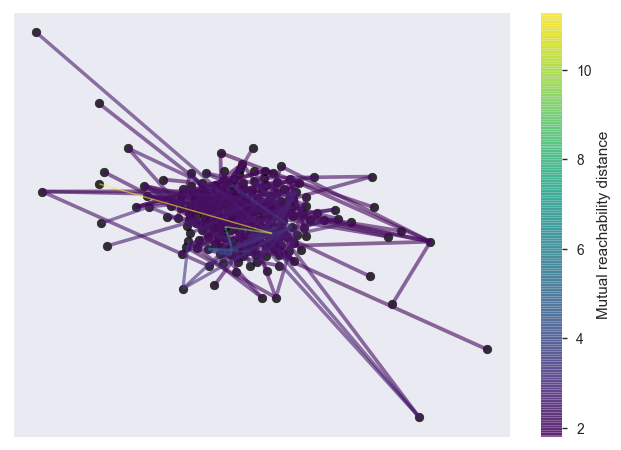

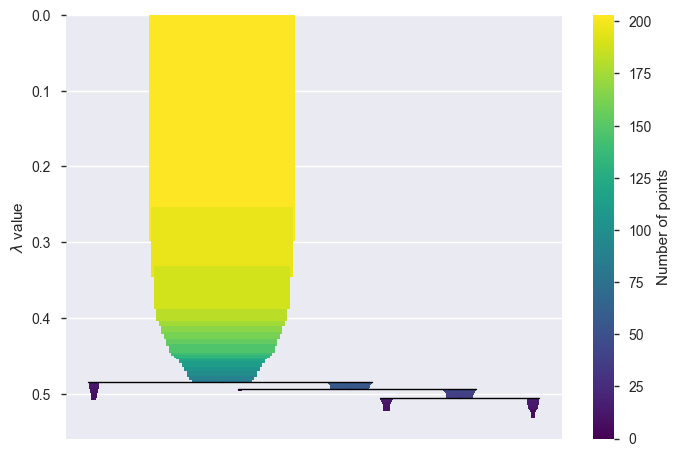

In [15]:
for target_class in list(y.value_counts().index):
    X_target = df.loc[df['TARGET'] == target_class]
    clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
    clusterer.fit(X_target)
    plt.figure()
    clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                          edge_alpha=0.6,
                                          edge_linewidth=1)
    plt.figure()
    clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
    palette = sns.color_palette()
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    X_target['cluster'] = pd.Series(clusterer.labels_)
    y_cluster = X_target['cluster']
    X_cluster = X_target.drop('cluster', axis=1)
    
    X_cluster.head()
    y_cluster.head()
    
    cluster_names = list(range(1, len(X_target['cluster'].value_counts()) + 1))

    dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
    dtc.fit(X_cluster.fillna(0), y_cluster.fillna(0))

    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

    SVG(graph.pipe(format='svg'))

# Cross-validation

In [16]:
X = X.drop('TARGET', axis=1)

In [17]:
X.shape, y.shape

((768, 29), (768,))

In [18]:
eval_size = 0.1
kf = StratifiedKFold(y, round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [19]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 29), (690,))

((78, 29), (78,))

# Models

In [20]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    }
}

## LightGBM

In [21]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 1,
 'is_unbalance': False,
 'learning_rate': 0.03,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 8,
 'objective': 'multiclass',
 'reg_alpha': 0.1,
 'reg_lambda': 0,
 'seed': 777,
 'subsample': 1}

Recall: 0.7096774193548387
Precision: 0.43137254901960786
Accuracy: 0.44871794871794873


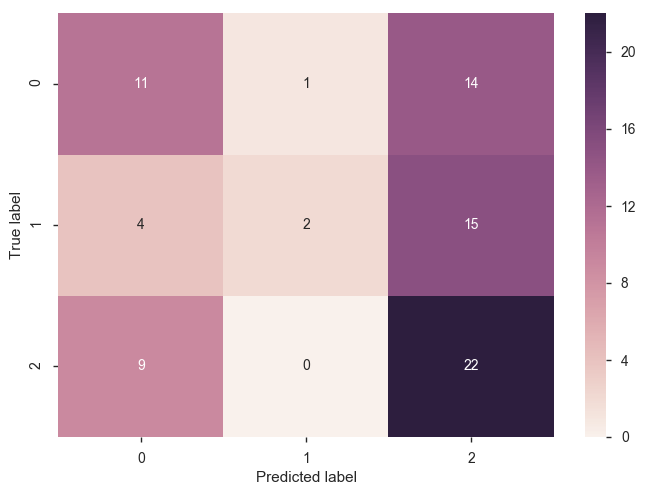

In [22]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

[1]	valid_0's multi_logloss: 1.09734
[2]	valid_0's multi_logloss: 1.09555
[3]	valid_0's multi_logloss: 1.0939
[4]	valid_0's multi_logloss: 1.09294
[5]	valid_0's multi_logloss: 1.0922
[6]	valid_0's multi_logloss: 1.09056
[7]	valid_0's multi_logloss: 1.09053
[8]	valid_0's multi_logloss: 1.08937
[9]	valid_0's multi_logloss: 1.0886
[10]	valid_0's multi_logloss: 1.08725
[11]	valid_0's multi_logloss: 1.08725
[12]	valid_0's multi_logloss: 1.08607
[13]	valid_0's multi_logloss: 1.08721
[14]	valid_0's multi_logloss: 1.08633
[15]	valid_0's multi_logloss: 1.08795
[16]	valid_0's multi_logloss: 1.08706
[17]	valid_0's multi_logloss: 1.08761
[18]	valid_0's multi_logloss: 1.08874
[19]	valid_0's multi_logloss: 1.08773
[20]	valid_0's multi_logloss: 1.08904
[21]	valid_0's multi_logloss: 1.08866
[22]	valid_0's multi_logloss: 1.0894
[23]	valid_0's multi_logloss: 1.09064
[24]	valid_0's multi_logloss: 1.09026
[25]	valid_0's multi_logloss: 1.09099
[26]	valid_0's multi_logloss: 1.09062
[27]	valid_0's multi_logl

Recall: 0.5483870967741935
Precision: 0.40476190476190477
Accuracy: 0.3974358974358974


Feature importance based on entropy:
Feature ranking with recursive feature elimination:


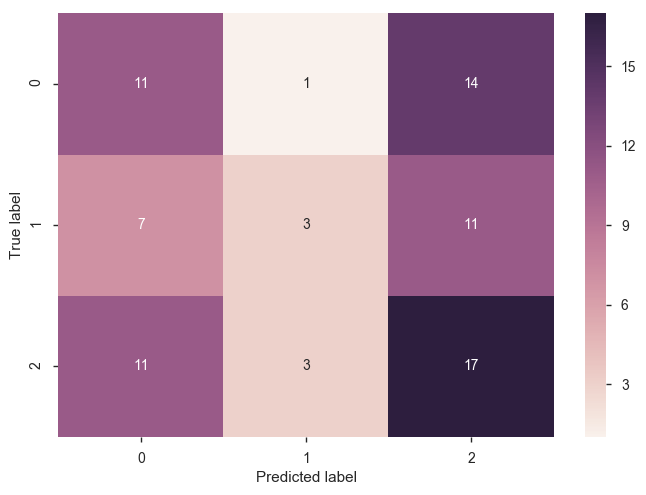

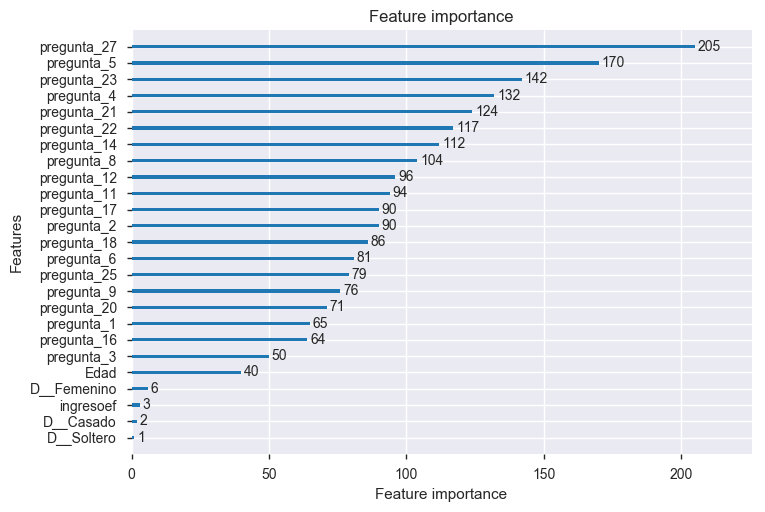

In [23]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)

y_pred = model.predict(X_valid)

y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)

cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['lightgbm']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['lightgbm']['precision'] = precision

accuracy = accuracy_score(y_pred_trunc, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['lightgbm']['accuracy'] = accuracy

lgb.plot_importance(model)

print('Feature importance based on entropy:')
d = dict(zip(model.feature_name(), model.feature_importance()))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['lightgbm']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['lightgbm']['fe_rfe'] = fe_rfe

## Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': 25,
 'min_samples_leaf': 10,
 'min_samples_split': 100,
 'n_estimators': 120}

Recall: 0.8064516129032258
Precision: 0.4032258064516129
Accuracy: 0.3974358974358974


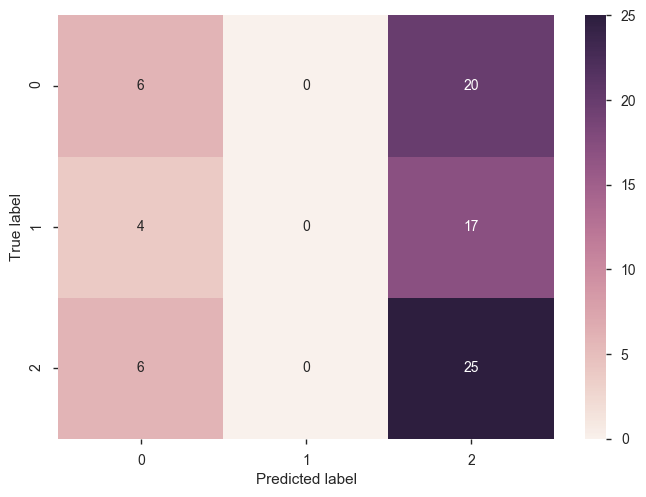

In [24]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=120, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.8064516129032258
Precision: 0.4032258064516129
Accuracy: 0.3974358974358974
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


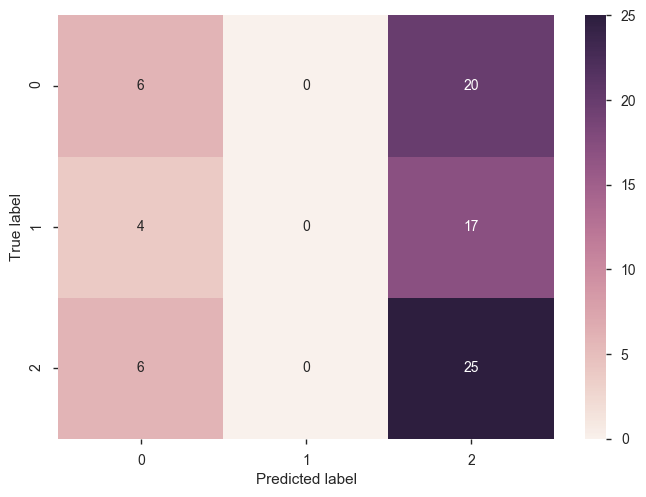

In [25]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['random_forest']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['random_forest']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['random_forest']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['random_forest']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['random_forest']['fe_rfe'] = fe_rfe

# Extra Trees

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 120}

Recall: 0.7096774193548387
Precision: 0.39285714285714285
Accuracy: 0.38461538461538464


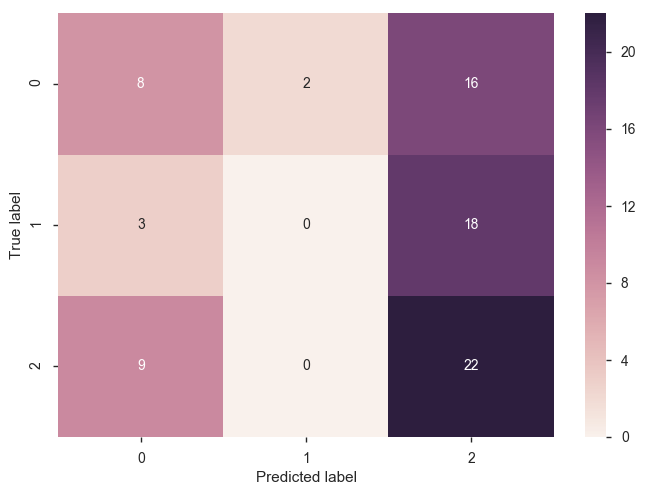

In [26]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=15, min_weight_fraction_leaf=0.0,
           n_estimators=120, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.7096774193548387
Precision: 0.39285714285714285
Accuracy: 0.38461538461538464
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


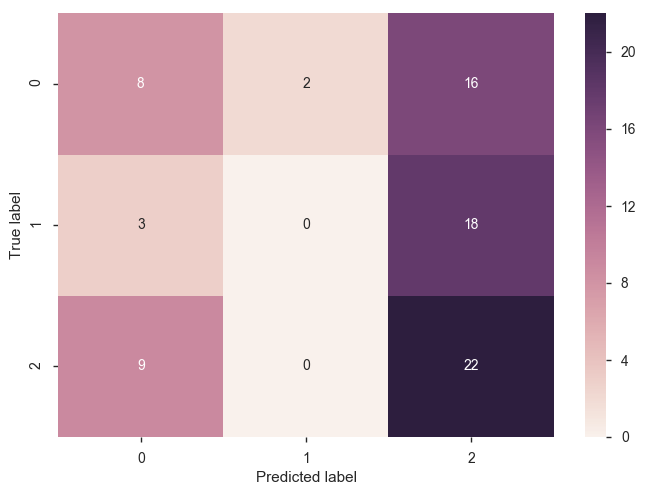

In [27]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['extra_trees']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['extra_trees']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['extra_trees']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['extra_trees']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['extra_trees']['fe_rfe'] = fe_rfe

### Garbage collection

In [30]:
del DecisionTreeClassifier, ExtraTreesClassifier, RandomForestClassifier, RandomizedSearchCV, RFE, SVG, Source, StratifiedKFold
del X, y, X_cluster, X_target, X_train, X_valid, accuracy, accuracy_score, clf, cluster_colors, clusterer, cm
del confusion_matrix, d, d_train, d_valid, dtc
del estimator, eval_size, export_graphviz, f1_score, fe_entropy, fe_rfe, g, graph, hdbscan
del kf, lgb, make_correlation_graphic, model, pandas_profiling, param_grid
del precision, precision_score, recall, recall_score, row, selector, target_class, train_ix, valid_ix, y_cluster, y_pred
del y_pred_trunc, y_train, y_valid
collect()

493

# Results

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


,entropy,rfe,N_entropy,N_rfe,score
D__Femenino,0.028401,23,0.145485,0.309318,0.454803
ingresoef,0.031638,21,0.162068,0.282420,0.444488
D__Soltero,0.030036,20,0.153861,0.268972,0.422833
D__Casado,0.022958,22,0.117604,0.295869,0.413473
pregunta_6,0.035980,17,0.184312,0.228626,0.412938
pregunta_8,0.037919,16,0.194245,0.215177,0.409422
D__Masculino,0.028322,18,0.145084,0.242075,0.387158
pregunta_22,0.034473,15,0.176590,0.201729,0.378319
pregunta_25,0.036030,14,0.184569,0.188280,0.372849
pregunta_1,0.038272,13,0.196054,0.174832,0.370885


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

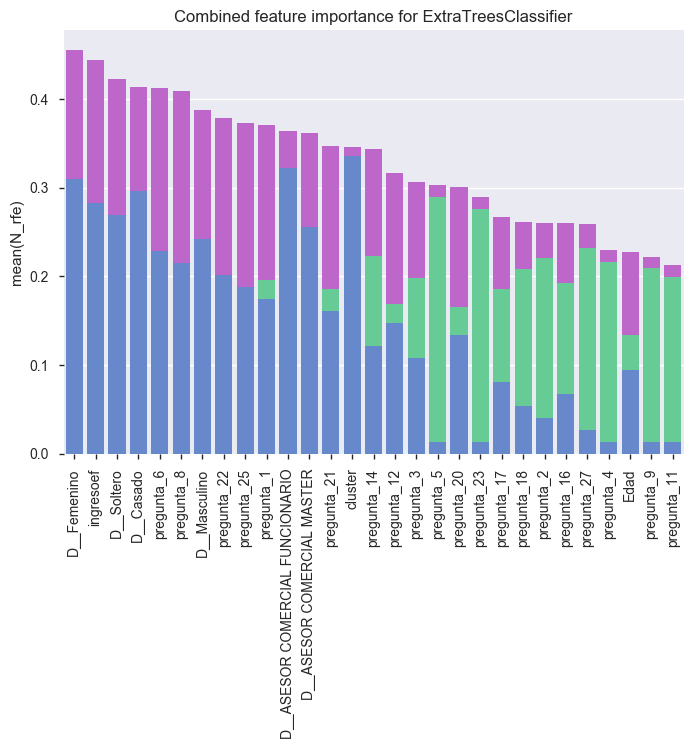

In [31]:
df1 = pd.DataFrame(model_results['extra_trees']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['extra_trees']['fe_rfe']).set_index(0)
results_extra_trees = pd.concat([df1, df2], axis=1)

results_extra_trees.columns = ['entropy', 'rfe']
results_extra_trees['N_entropy'] = normalize(results_extra_trees['entropy'])[0]
results_extra_trees['N_rfe'] = normalize(results_extra_trees['rfe'])[0]

results_extra_trees['score'] = results_extra_trees['N_entropy'] + results_extra_trees['N_rfe']

results_extra_trees = results_extra_trees.sort_values('score', ascending=False)

results_extra_trees

plt.title('Combined feature importance for ExtraTreesClassifier')
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_extra_trees.index, y=results_extra_trees['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


,entropy,rfe,N_entropy,N_rfe,score
pregunta_23,0.090241,6,0.389693,0.080692,0.470384
pregunta_18,0.058206,14,0.251352,0.188280,0.439633
pregunta_5,0.089086,1,0.384705,0.013449,0.398153
pregunta_1,0.032821,17,0.141731,0.228626,0.370357
D__Casado,0.004847,24,0.020930,0.322766,0.343696
pregunta_2,0.057492,7,0.248270,0.094140,0.342410
pregunta_6,0.032420,15,0.139999,0.201729,0.341728
cluster,0.000552,25,0.002383,0.336215,0.338597
pregunta_27,0.068709,3,0.296709,0.040346,0.337055
pregunta_17,0.039295,12,0.169689,0.161383,0.331072


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

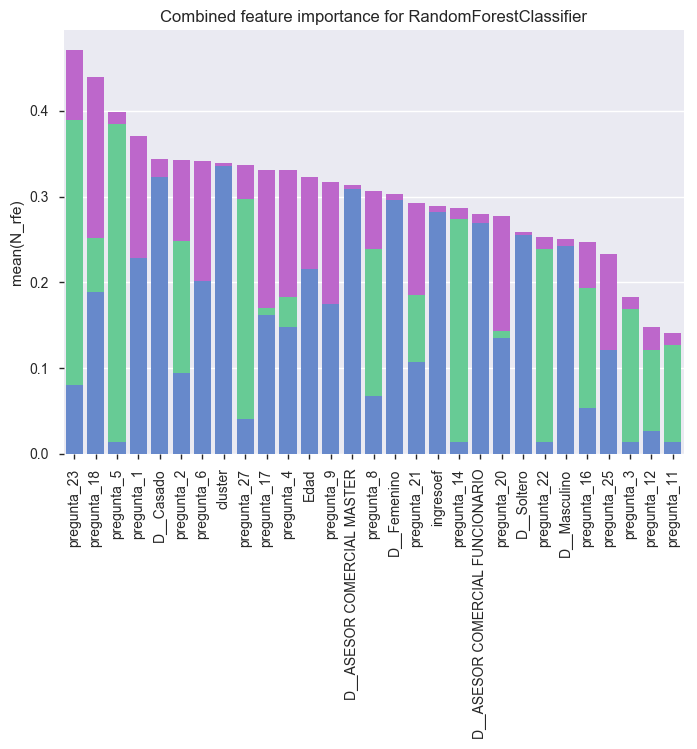

In [32]:
df1 = pd.DataFrame(model_results['random_forest']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['random_forest']['fe_rfe']).set_index(0)
results_random_forest = pd.concat([df1, df2], axis=1)

results_random_forest.columns = ['entropy', 'rfe']
results_random_forest['N_entropy'] = normalize(results_random_forest['entropy'])[0]
results_random_forest['N_rfe'] = normalize(results_random_forest['rfe'])[0]

results_random_forest['score'] = results_random_forest['N_entropy'] + results_random_forest['N_rfe']

results_random_forest = results_random_forest.sort_values('score', ascending=False)

results_random_forest

plt.title('Combined feature importance for RandomForestClassifier')
sns.barplot(x=results_random_forest.index, y=results_random_forest['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_random_forest.index, y=results_random_forest['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

,pregunta_27,pregunta_5,pregunta_23,pregunta_4,pregunta_21,pregunta_22,pregunta_14,pregunta_8,pregunta_12,pregunta_11,...,pregunta_3,Edad,D__Femenino,ingresoef,D__Casado,D__Soltero,cluster,D__ASESOR_COMERCIAL_FUNCIONARIO,D__Masculino,D__ASESOR_COMERCIAL_MASTER
1,205,170,142,132,124,117,112,104,96,94,...,50,40,6,3,2,1,0,0,0,0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


,entropy,rfe,N_entropy,N_rfe,score
pregunta_27,205,10,0.419614,0.134486,0.554099
pregunta_17,90,16,0.184221,0.215177,0.399398
pregunta_5,170,1,0.347972,0.013449,0.361421
pregunta_18,86,13,0.176033,0.174832,0.350865
pregunta_20,71,15,0.145330,0.201729,0.347058
pregunta_2,90,12,0.184221,0.161383,0.345604
pregunta_23,142,4,0.290659,0.053794,0.344453
cluster,0,25,0.000000,0.336215,0.336215
pregunta_21,124,6,0.253815,0.080692,0.334507
D__ASESOR COMERCIAL FUNCIONARIO,0,24,0.000000,0.322766,0.322766


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

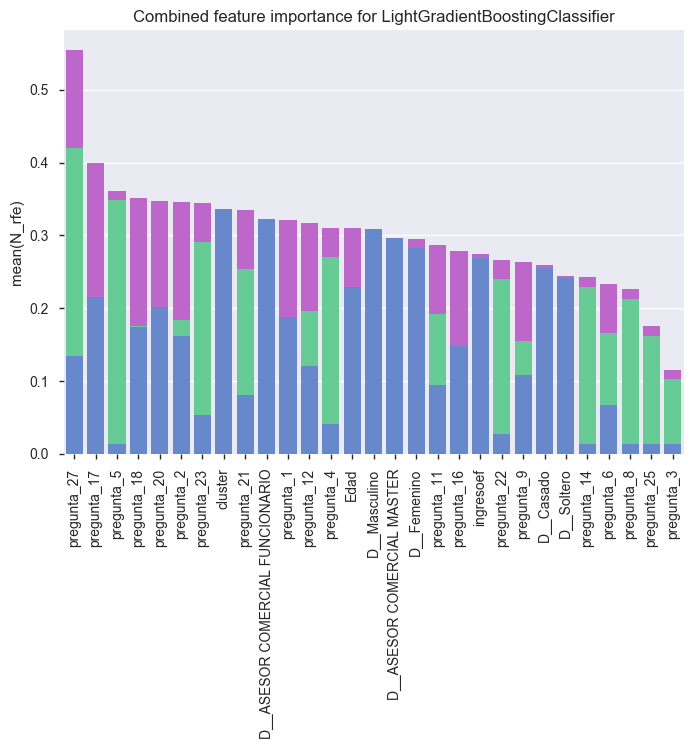

In [33]:
df1 = pd.DataFrame(model_results['lightgbm']['fe_entropy']).set_index(0)
df2 = pd.DataFrame(model_results['lightgbm']['fe_rfe']).set_index(0)

df1 = df1.T
df1

for feature in [col for col in df1.columns if col.startswith('D_')]:
    df1 = df1.rename(columns={
        feature: feature.replace('_', ' ').replace('D  ', 'D__')
    })

df1 = df1.T
    
results_lightgbm = pd.concat([df1, df2], axis=1)

results_lightgbm.columns = ['entropy', 'rfe']
results_lightgbm['N_entropy'] = normalize(results_lightgbm['entropy'])[0]
results_lightgbm['N_rfe'] = normalize(results_lightgbm['rfe'])[0]

results_lightgbm['score'] = results_lightgbm['N_entropy'] + results_lightgbm['N_rfe']

results_lightgbm = results_lightgbm.sort_values('score', ascending=False)

results_lightgbm

plt.title('Combined feature importance for LightGradientBoostingClassifier')
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['score'], color=sns.color_palette("hls", 5)[4])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_entropy'], color=sns.color_palette("hls", 5)[2])
sns.barplot(x=results_lightgbm.index, y=results_lightgbm['N_rfe'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)

,extra_trees,random_forest,lightgbm,score
pregunta_27,0.259503,0.337055,0.554099,1.150656
pregunta_23,0.289155,0.470384,0.344453,1.103992
pregunta_5,0.303494,0.398153,0.361421,1.063068
pregunta_1,0.370885,0.370357,0.321328,1.062571
D__Femenino,0.454803,0.303035,0.294702,1.052540
pregunta_18,0.261653,0.439633,0.350865,1.052150
cluster,0.345446,0.338597,0.336215,1.020258
D__Casado,0.413473,0.343696,0.259617,1.016786
ingresoef,0.444488,0.289045,0.275112,1.008646
pregunta_17,0.267039,0.331072,0.399398,0.997509


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

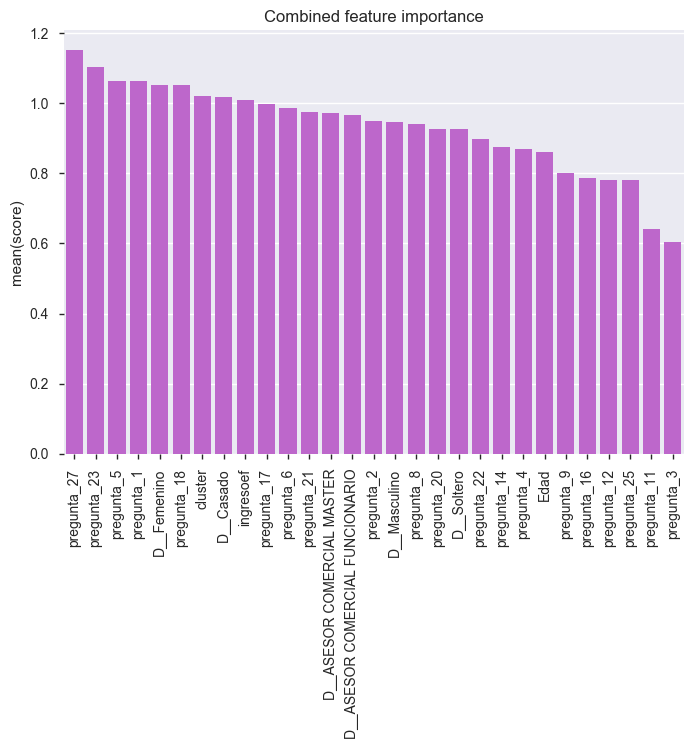

In [34]:
df_results = pd.concat([results_extra_trees['score'], results_random_forest['score'], results_lightgbm['score']], axis=1)
df_results.columns = ['extra_trees', 'random_forest', 'lightgbm']
df_results['score'] = df_results['extra_trees'] + df_results['random_forest'] + df_results['lightgbm']

df_results = df_results.sort_values('score', ascending=False)

df_results

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[4])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

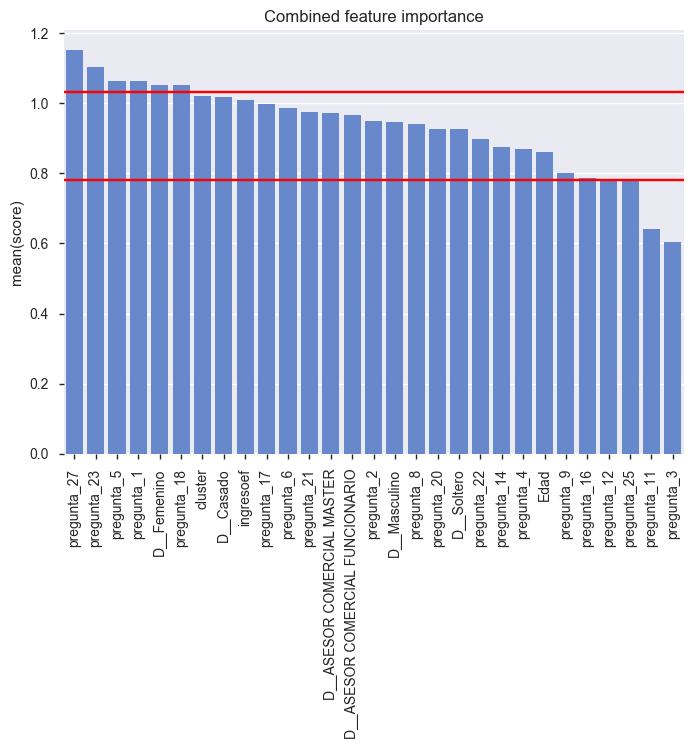

In [35]:
margin1 = 0.1
margin2 = 0.8

plt.title('Combined feature importance')
sns.barplot(x=df_results.index, y=df_results['score'], color=sns.color_palette("hls", 5)[3])
plt.xticks(rotation=90)
sns.plt.axhline(df_results['score'].quantile(margin1), color='r')
sns.plt.axhline(df_results['score'].quantile(margin2), color='r')

In [36]:
categories = ['bad_uncertain', 'uncertain', 'good_uncertain']
cuts = [
    min(df_results['score']), 
    df_results['score'].quantile(margin1), 
    df_results['score'].quantile(margin2), 
    max(df_results['score'])
]
df_results['score'] = pd.cut(df_results['score'], cuts, labels=categories, include_lowest=True)
df_results['score']

pregunta_27                        good_uncertain
pregunta_23                        good_uncertain
pregunta_5                         good_uncertain
pregunta_1                         good_uncertain
D__Femenino                        good_uncertain
pregunta_18                        good_uncertain
cluster                                 uncertain
D__Casado                               uncertain
ingresoef                               uncertain
pregunta_17                             uncertain
pregunta_6                              uncertain
pregunta_21                             uncertain
D__ASESOR COMERCIAL MASTER              uncertain
D__ASESOR COMERCIAL FUNCIONARIO         uncertain
pregunta_2                              uncertain
D__Masculino                            uncertain
pregunta_8                              uncertain
pregunta_20                             uncertain
D__Soltero                              uncertain
pregunta_22                             uncertain


In [37]:
df_results.to_csv('hk1_uncertain_pass_results.csv')